In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.applications import VGG19
from keras.applications import VGG16, EfficientNetB7, NASNetMobile, MobileNetV2

2024-02-07 20:05:21.302184: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 20:05:21.302321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 20:05:21.464489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 5

In [4]:
# Load image data
def load_train_data(folder_path):
    X = []
    y = []
    class_names = os.listdir(folder_path)
    print(class_names)
    
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = load_img(image_path, target_size=IMAGE_SIZE)
            image = img_to_array(image)
            X.append(image)
            y.append(i)
    X = np.array(X)
    y = np.array(y)
    return X, y


# Load image data
def load_test_data(folder_path):
    X = []
    filenames = []
    for image_name in os.listdir(folder_path):
        if image_name.endswith('.jpg'):
            image_path = os.path.join(folder_path, image_name)
            image = load_img(image_path, target_size=IMAGE_SIZE)
            image = img_to_array(image)
            X.append(image)
            filenames.append(image_name)
    X = np.array(X)
    return X, filenames


# Load training and testing data
train_folder = '/kaggle/input/flowers-dataset/train'
test_folder = '/kaggle/input/flowers-dataset/test'
X_train, y_train = load_train_data(train_folder)
X_test, test_filenames = load_test_data(test_folder)

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']


## Displaying Random Sample from teh Training Data

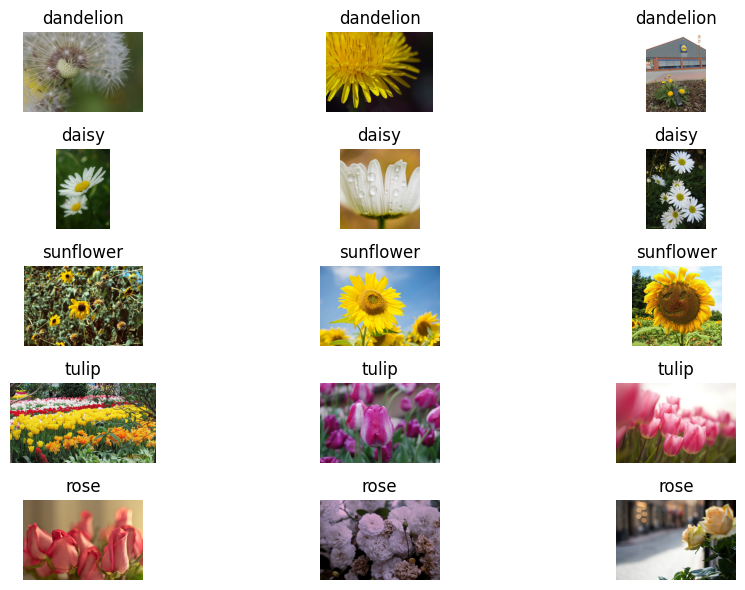

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

# Define function to display sample images
def display_sample_images(folder_path, class_names, num_samples=3):
    plt.figure(figsize=(10, 6))
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        image_names = os.listdir(class_path)[:num_samples]
        for j, image_name in enumerate(image_names):
            image_path = os.path.join(class_path, image_name)
            image = Image.open(image_path)
            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get class names
train_class_names = os.listdir(train_folder)

# Display sample images
display_sample_images(train_folder, train_class_names)

In [6]:
# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## VGG16 Class From Scratch

In [7]:
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
# from tensorflow.keras.models import Model

# class VGG16:
#     def __init__(self, input_shape=(224, 224, 3), num_classes=5):
#         self.input_shape = input_shape
#         self.num_classes = num_classes
#         self.model = self.build_model()

#     def build_model(self):
#         input_layer = Input(shape=self.input_shape)
        
#         # Block 1
#         x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_layer)
#         x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
#         x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

#         # Block 2
#         x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
#         x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
#         x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

#         # Block 3
#         x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
#         x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
#         x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
#         x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

#         # Block 4
#         x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
#         x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
#         x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
#         x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

#         # Block 5
#         x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
#         x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
#         x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
#         x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

#         # Classification block
#         x = Flatten(name='flatten')(x)
#         x = Dense(4096, activation='relu', name='fc1')(x)
#         x = Dense(4096, activation='relu', name='fc2')(x)
#         output_layer = Dense(self.num_classes, activation='softmax', name='predictions')(x)

#         model = Model(inputs=input_layer, outputs=output_layer, name='vgg16')
#         return model

# # Example usage:
# vgg_model = VGG16()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#A21212;
           font-size:200%;
           font-family:Serif;
           letter-spacing:0.5px">

<p style="padding: 10px;
          color:white;
          font-size:150%;
          text-align:center;">
VGG-16
</p>
</div>

In [8]:
# Define VGG16 model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(vgg16_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

# Freeze convolutional base
vgg16_base.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
checkpoint = ModelCheckpoint('flower_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val), callbacks=[checkpoint])

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 21138757 (80.64 MB)
Trainable params: 6424069 (24.51 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/10


I0000 00:00:1707336370.776741      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


69/69 [==============================] - ETA: 0s - loss: 1.6722 - accuracy: 0.6134
Epoch 1: val_loss improved from inf to 95.28980, saving model to flower_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 18s 166ms/step - loss: 1.6722 - accuracy: 0.6134 - val_loss: 95.2898 - val_accuracy: 0.7800
Epoch 2/10
69/69 [==============================] - ETA: 0s - loss: 0.5131 - accuracy: 0.8629
Epoch 2: val_loss did not improve from 95.28980
69/69 [==============================] - 6s 85ms/step - loss: 0.5131 - accuracy: 0.8629 - val_loss: 167.4590 - val_accuracy: 0.7145
Epoch 3/10
69/69 [==============================] - ETA: 0s - loss: 0.4572 - accuracy: 0.8953
Epoch 3: val_loss did not improve from 95.28980
69/69 [==============================] - 6s 85ms/step - loss: 0.4572 - accuracy: 0.8953 - val_loss: 198.1803 - val_accuracy: 0.7655
Epoch 4/10
69/69 [==============================] - ETA: 0s - loss: 0.3035 - accuracy: 0.9244
Epoch 4: val_loss did not improve from 95.28980
69/69 [==============================] - 6s 84ms/step - loss: 0.3035 - accuracy: 0.9244 - val_loss: 158.8846 - val_accuracy: 0.7382
Epoch 5/10
69/69 [===========================

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#A21212;
           font-size:200%;
           font-family:Serif;
           letter-spacing:0.5px">

<p style="padding: 10px;
          color:white;
          font-size:150%;
          text-align:center;">
VGG-19 Model
</p>
</div>

In [9]:
# Define VGG19 model
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(vgg19_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

# Freeze convolutional base
vgg19_base.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
checkpoint = ModelCheckpoint('flower_vgg19_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val), callbacks=[checkpoint])

80134624/80134624 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 26448453 (100.89 MB)
Trainable params: 6424069 (24.51 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________
Epoch 1/10
69/69 [==============================] - ETA: 0s - loss: 1.943

In [10]:
model.evaluate(X_val,y_val)

18/18 [==============================] - 1s 77ms/step - loss: 124.0707 - accuracy: 0.7382


[124.0706787109375, 0.7381818294525146]

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#A21212;
           font-size:200%;
           font-family:Serif;
           letter-spacing:0.5px">

<p style="padding: 10px;
          color:white;
          font-size:150%;
          text-align:center;">
Mobile Net
</p>
</div>

In [11]:
import tensorflow_hub as hub

pretrained_layer = Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" , input_shape = (224,224,3))
])

model = Sequential([
    pretrained_layer ,
    Dense(5,activation = 'softmax')
])

In [12]:
# Model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
checkpoint = ModelCheckpoint('flower_mobilenet_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val), callbacks=[checkpoint])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
Epoch 1/10
69/69 [==============================] - ETA: 0s - loss: 0.8652 - accuracy: 0.6790
Epoch 1: val_loss improved from inf to 0.46598, saving model to flower_mobilenet_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 10s 80ms/step - loss: 0.8652 - accuracy: 0.6790 - val_loss: 0.4660 - val_accuracy: 0.8345
Epoch 2/10
69/69 [==============================] - ETA: 0s - loss: 0.3965 - accuracy: 0.8725
Epoch 2: val_loss improved from 0.46598 to 0.38353, saving model to flower_mobilenet_model.h5
69/69 [==============================] - 3s 38ms/step - loss: 0.3965 - accuracy: 0.8725 - val_loss: 0.3835 - val_accuracy: 0.8564
Epoch 3/10
67/69 [============================>.] - ETA: 0s - loss: 0.3066 - accuracy: 0.9086
Epoch 3: val_loss improved from 0.38353 to 0.36872, saving model to flower_mobilenet_model.h5
69/69 [==============================] - 3s 39ms/step - loss: 0.3046 - accuracy: 0.9089 - val_loss: 0.3687 - val_accuracy: 0.8673
Epoch 4/10
67/69 [============================>.] - ETA: 0s - loss: 0.2508 - accuracy: 0.9216
Epoch 4: val_loss improved from 0.36872 to 0.34184, saving model to flower_mobilenet_model.h5
69/69 [==============================] - 3s 3

In [13]:
model.evaluate(X_val,y_val)

18/18 [==============================] - 1s 27ms/step - loss: 0.3267 - accuracy: 0.9018


[0.3267323672771454, 0.9018181562423706]

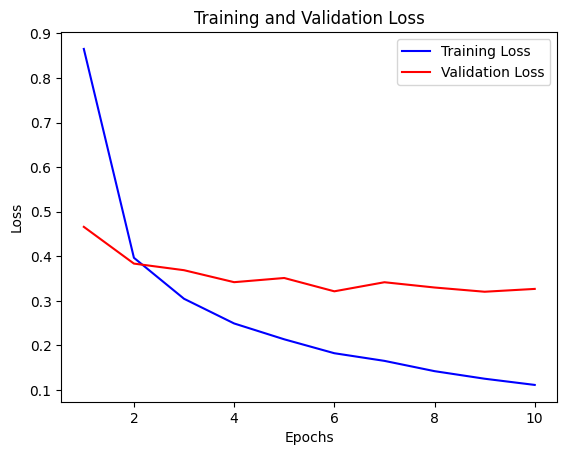

In [14]:
import matplotlib.pyplot as plt

# Extract training and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting training and validation loss
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b-', label='Training Loss')  # Change 'bo' to 'b-'
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

29/29 [==============================] - 2s 51ms/step


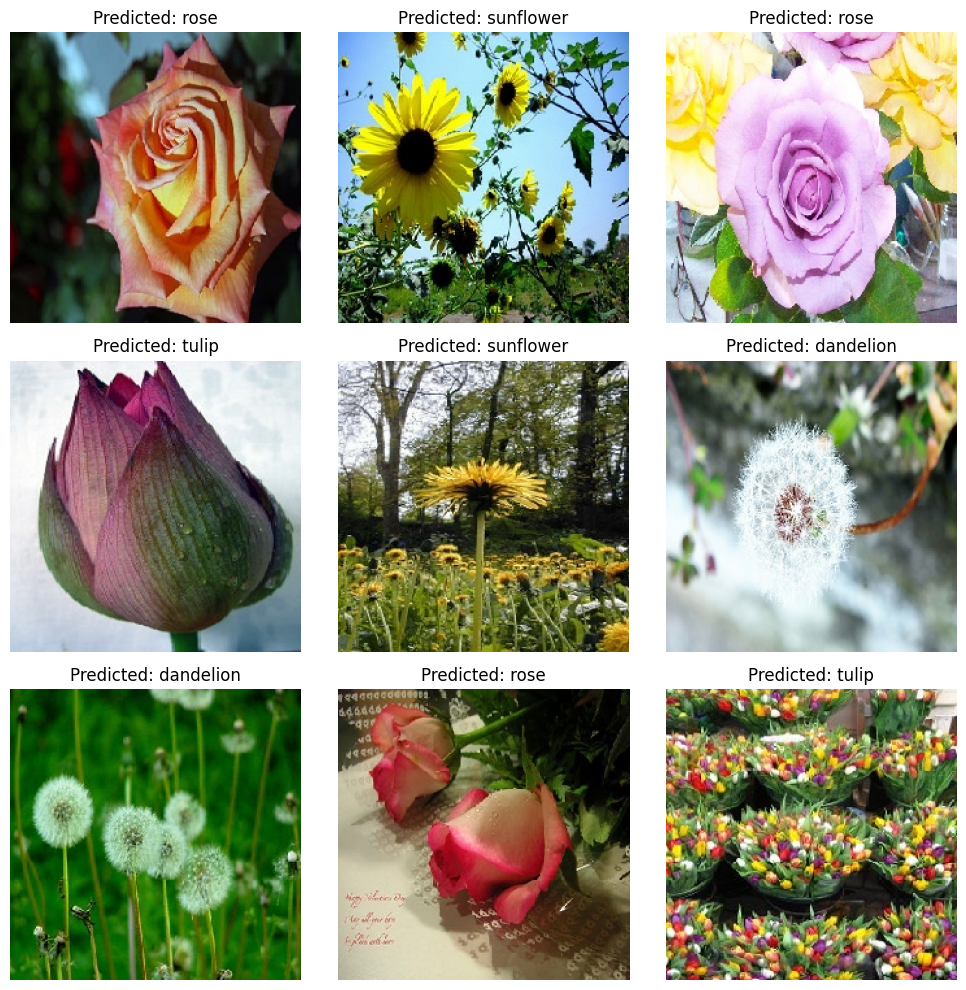

In [15]:
# Predict class names for test data
test_predictions = model.predict(X_test)
class_names = os.listdir(train_folder)
class_to_index = {class_name: i for i, class_name in enumerate(class_names)}
index_to_class = {i: class_name for i, class_name in enumerate(class_names)}
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_predictions_class_names = [index_to_class[idx] for idx in test_predictions_classes]

# Plot some images with predicted classes
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i])
    plt.title("Predicted: {}".format(test_predictions_class_names[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()

## Confusion Matrix

18/18 [==============================] - 0s 26ms/step


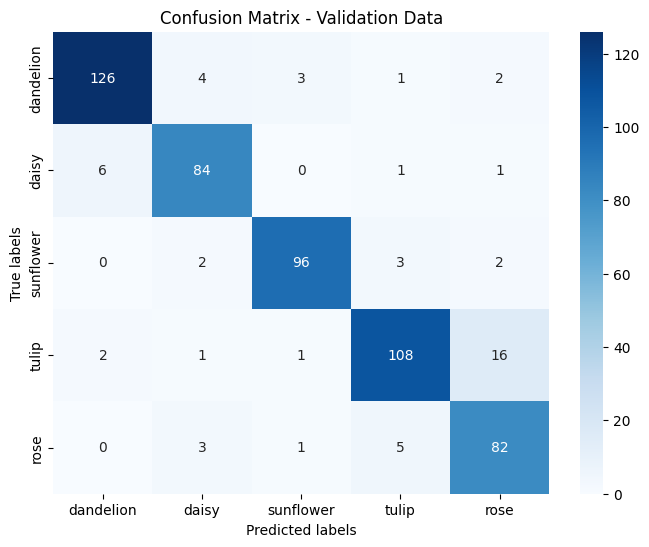

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get true labels and predicted labels for validation data
y_true_val = y_val
y_pred_val = np.array([np.argmax(pred) for pred in model.predict(X_val)])

# Compute confusion matrix
conf_mat_val = confusion_matrix(y_true_val, y_pred_val)

# Plot confusion matrix for validation data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_val, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Validation Data')
plt.show()


## ROC Curve

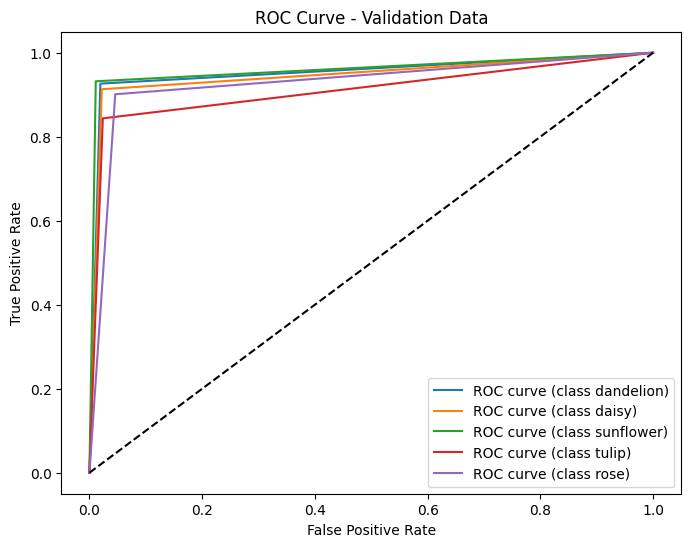

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve for validation data
fpr_val = dict()
tpr_val = dict()
roc_auc_val = dict()
for i in range(NUM_CLASSES):
    fpr_val[i], tpr_val[i], _ = roc_curve((y_true_val == i).astype(int), (y_pred_val == i).astype(int))
    roc_auc_val[i] = auc(fpr_val[i], tpr_val[i])

# Plot ROC curve for validation data
plt.figure(figsize=(8, 6))
for i in range(NUM_CLASSES):
    plt.plot(fpr_val[i], tpr_val[i], label='ROC curve (class {})'.format(class_names[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Data')
plt.legend(loc="lower right")
plt.show()

## Classification report

In [18]:
from sklearn.metrics import classification_report

# Print classification report
print("Classification Report:\n", classification_report(y_true_val, y_pred_val, target_names=class_names))

Classification Report:
               precision    recall  f1-score   support

   dandelion       0.94      0.93      0.93       136
       daisy       0.89      0.91      0.90        92
   sunflower       0.95      0.93      0.94       103
       tulip       0.92      0.84      0.88       128
        rose       0.80      0.90      0.85        91

    accuracy                           0.90       550
   macro avg       0.90      0.90      0.90       550
weighted avg       0.90      0.90      0.90       550



In [19]:
# Create CSV file for test predictions
test_results_df = pd.DataFrame({'Filename': test_filenames, 'Predicted_Class': test_predictions_class_names})
test_results_df.to_csv('test_predictions.csv', index=False)